In [1]:
%matplotlib inline

# ignore warnings
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

from joblib import load
from ruamel.yaml import YAML
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import h5py

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, GridSearchCV, ShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.utils import resample

from umda import paths
from umda.data import load_data, load_pipeline
from umda import training

In [2]:
seed = 1215677
normalize = False
mask = False

In [4]:
state = np.random.default_rng(seed)

full_X, full_cluster_ids, tmc1_df = load_data()
embedder = load_pipeline()

tmc1_X = np.vstack([embedder.vectorize(smi) for smi in tmc1_df["SMILES"]])
tmc1_y = np.log10(tmc1_df["Column density (cm^-2)"].to_numpy())

boot_X, boot_y = training.get_bootstrap_samples((tmc1_X, tmc1_y), seed, 500)

In [5]:
with open("model_hparams.yml") as read_file:
    hparams = YAML().load(read_file)

In [6]:
gp_kernel = kernels.ConstantKernel() * \
    kernels.RBF(3.0, (1e-1, 10.0)) + \
    kernels.RationalQuadratic(200.0, 20.0, alpha_bounds=(1e-3, 5e2), length_scale_bounds=(50.0, 1e4)) * \
        kernels.ConstantKernel() + kernels.ConstantKernel()

In [7]:
base_models = {
    "linear_regression": LinearRegression(),
    "ridge": Ridge(),
    "br": BayesianRidge(),
    "svr": SVR(),
    "knn": KNeighborsRegressor(),
    "rfr": RandomForestRegressor(random_state=seed),
    "gbr": GradientBoostingRegressor(random_state=seed),
    "gpr": GaussianProcessRegressor(
        kernel=gp_kernel, random_state=seed
    )
}

models = {key: training.compose_model(value, normalize) for key, value in base_models.items()}

## RFR

In [8]:
rfr = models.get("rfr")

In [9]:
rfr_result = rfr.fit(tmc1_X, tmc1_y)

In [32]:
rfr_result["regressor"].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1215677,
 'verbose': 0,
 'warm_start': False}

In [11]:
r2_score(tmc1_y, rfr_result.predict(tmc1_X))

0.8690666691002383

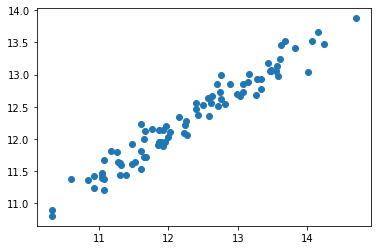

In [19]:
plt.scatter(tmc1_y, rfr_result.predict(tmc1_X))

## Figuring out feature importance for SVR

In [7]:
svr_cv = training.random_cv_search((tmc1_X, tmc1_y), models["svr"], hparams["svr"], seed, verbose=1, n_splits=5, n_jobs=32, scoring="r2", n_iter=100)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [111]:
svr_df = pd.DataFrame(svr_cv.cv_results_)
for key in ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'mean_test_score', 'std_test_score', 'rank_test_score']:
    del svr_df[key]
svr_df["param_regressor__kernel"] = OrdinalEncoder().fit_transform(svr_df["param_regressor__kernel"].values[:,None]).flatten()
# br_df["param_regressor__normalize"] = br_df["param_regressor__normalize"].astype(float)
# replace None's as "zero" encoding
svr_df = svr_df.replace([None], 0)

In [112]:
results = list()
for index, row in svr_df.iterrows():
    row_params = {key: value for key, value in row.items() if "param_" in key}
    for key, value in row.items():
        if "test_score" in key:
            row_params["score"] = value
            results.append(deepcopy(row_params))

In [113]:
svr_training_df = pd.DataFrame(results)

In [114]:
hparam_rfr = RandomForestRegressor()

In [115]:
features = svr_training_df[[f"param_regressor__{feature}" for feature in hparams["svr"].keys()]].to_numpy()

In [116]:
features

array([[0.00000000e+00, 2.18214882e+02, 5.33798176e-02, 6.45363581e-02],
       [0.00000000e+00, 2.18214882e+02, 5.33798176e-02, 6.45363581e-02],
       [0.00000000e+00, 2.18214882e+02, 5.33798176e-02, 6.45363581e-02],
       ...,
       [0.00000000e+00, 7.18242135e+01, 8.06556765e-02, 1.13390668e-02],
       [0.00000000e+00, 7.18242135e+01, 8.06556765e-02, 1.13390668e-02],
       [0.00000000e+00, 7.18242135e+01, 8.06556765e-02, 1.13390668e-02]])

In [117]:
result = hparam_rfr.fit(features, svr_training_df["score"].to_numpy()[:,None])

In [118]:
result.feature_importances_

array([0.32767582, 0.22945026, 0.25748786, 0.18538606])

In [119]:
r2_score(svr_training_df["score"].to_numpy(), result.predict(features))

0.3788493295165969

In [129]:
np.abs(svr_training_df["score"]).argmin()

186

In [130]:
svr_training_df.iloc[186]

param_regressor__C          269.997175
param_regressor__epsilon      0.034810
param_regressor__gamma        0.059872
param_regressor__kernel       1.000000
score                        -0.013942
Name: 186, dtype: float64

In [128]:
svr_cv.best_score_

-0.2069143131757462

## Hyperparameter importance determination for ridge regression

From below, it seems like we just need a very small amount of regularization - $\alpha$ should be on the order of typical weight decay values (~$10^{-5}$)

In [7]:
ridge_cv = training.random_cv_search(
    (tmc1_X, tmc1_y), 
    models["ridge"],
    {
        "alpha": np.power(10, np.linspace(-5., -3., 20)),
        "fit_intercept": [True, False],
        "normalize": [False]
    },
    seed, 
    verbose=1, n_splits=50, n_jobs=32, scoring="r2", n_iter=100, refit=False)

Fitting 50 folds for each of 100 candidates, totalling 5000 fits


In [8]:
ridge_cv.best_params_

{'regressor__alpha': 0.0010074972692111022,
 'regressor__fit_intercept': True,
 'regressor__normalize': False}

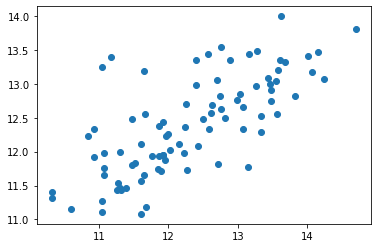

In [22]:
plt.scatter(tmc1_y, best_estimator.predict(tmc1_X))

In [20]:
r2_score(tmc1_y, best_estimator.predict(tmc1_X))

0.5089328554582189

In [14]:
best_estimator, best_train_error, best_test_error, best_performance, best_split, log = training.standardized_fit_test((tmc1_X, tmc1_y), models["ridge"], ridge_cv.best_params_, seed, test_size=0.1)

In [19]:
pd.DataFrame(log).sort_values(["performance", "r2"], ascending=[True, False])

,train_error,test_error,performance,r2,train_index,test_index
72,0.434542,0.426567,0.007975,0.562906,"[67, 12, 75, 26, 70, 81, 23, 86, 85, 33, 66, 4...","[25, 42, 36, 76, 24, 27, 73, 34, 59]"
93,0.437157,0.407756,0.029402,0.562504,"[23, 32, 62, 5, 28, 48, 66, 33, 84, 24, 11, 8,...","[49, 0, 64, 73, 56, 58, 72, 16, 59]"
83,0.440853,0.404238,0.036615,0.559532,"[55, 73, 66, 64, 44, 22, 29, 70, 72, 15, 57, 4...","[11, 54, 58, 7, 40, 21, 43, 28, 24]"
58,0.445974,0.405025,0.040949,0.554823,"[11, 18, 20, 70, 65, 54, 44, 86, 84, 21, 46, 2...","[76, 74, 34, 10, 81, 26, 82, 71, 69]"
36,0.446191,0.401332,0.044859,0.555012,"[73, 2, 68, 51, 41, 80, 30, 28, 17, 42, 70, 56...","[39, 63, 13, 4, 75, 58, 7, 46, 26]"
...,...,...,...,...,...,...
99,0.349057,1.685151,1.336094,0.508933,"[71, 84, 15, 0, 65, 23, 75, 69, 35, 20, 51, 4,...","[58, 62, 13, 47, 85, 68, 67, 18, 61]"
85,0.426649,1.829314,1.402665,0.423796,"[46, 6, 7, 29, 50, 34, 37, 17, 75, 49, 1, 70, ...","[74, 66, 43, 59, 53, 28, 0, 83, 54]"
26,0.413512,2.014728,1.601216,0.416335,"[77, 60, 13, 51, 20, 43, 8, 16, 37, 19, 75, 72...","[62, 38, 32, 26, 52, 86, 83, 67, 79]"
48,0.381544,2.197437,1.815893,0.426172,"[39, 48, 66, 31, 81, 25, 51, 84, 42, 38, 21, 1...","[67, 43, 33, 83, 82, 50, 63, 1, 3]"


In [450]:
br_cv = training.random_cv_search(
    (tmc1_X, tmc1_y), 
    models["br"],
    {
        "alpha_1": [1e5],
        "alpha_2": [1e5],
        "lambda_1": [1e5],
        "lambda_2": [1e5],
        "alpha_init": [100.],
        "lambda_init": [100.],
        "fit_intercept": [False],
        "normalize": [False],
        "tol": [1e-7]
    },
    seed, 
    verbose=1, n_splits=50, n_jobs=32, scoring="neg_mean_squared_error", n_iter=100, refit=True)

Fitting 50 folds for each of 100 candidates, totalling 5000 fits


In [451]:
br_cv.best_params_

{'regressor__alpha_1': 105950.1413280287,
 'regressor__alpha_2': 161155.20161565725,
 'regressor__alpha_init': 106.59356628133449,
 'regressor__fit_intercept': False,
 'regressor__lambda_1': 183212.70320545422,
 'regressor__lambda_2': 102131.38421011587,
 'regressor__lambda_init': 190.97482873524925,
 'regressor__normalize': False,
 'regressor__tol': 1.021379933692089e-07}

In [452]:
br_cv.best_estimator_["regressor"].lambda_, br_cv.best_estimator_["regressor"].alpha_

(1.793981700571508, 0.6575428437005848)

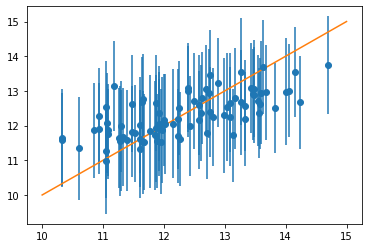

In [454]:
pred_y, pred_std = br_cv.best_estimator_.predict(tmc1_X, return_std=True)
plt.errorbar(tmc1_y, pred_y, yerr=pred_std, fmt="o")
plt.plot(np.arange(10., 16), np.arange(10., 16))

In [455]:
r2_score(tmc1_y, pred_y)

0.4789820009186134

In [456]:
SVR?

Init signature:
SVR(
    *,
    kernel='rbf',
    degree=3,
    gamma='scale',
    coef0=0.0,
    tol=0.001,
    C=1.0,
    epsilon=0.1,
    shrinking=True,
    cache_size=200,
    verbose=False,
    max_iter=-1,
)
Docstring:     
Epsilon-Support Vector Regression.

The free parameters in the model are C and epsilon.

The implementation is based on libsvm. The fit time complexity
is more than quadratic with the number of samples which makes it hard
to scale to datasets with more than a couple of 10000 samples. For large
datasets consider using :class:`~sklearn.svm.LinearSVR` or
:class:`~sklearn.linear_model.SGDRegressor` instead, possibly after a
:class:`~sklearn.kernel_approximation.Nystroem` transformer.

Read more in the :ref:`User Guide <svm_regression>`.

Parameters
----------
kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}, default='rbf'
     Specifies the kernel type to be used in the algorithm.
     It must be one of 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed

In [518]:
svr_cv = training.grid_cv_search(
    (tmc1_X, tmc1_y), 
    models["svr"],
    {
        "C": [10.],
        "gamma": [1e-3, 1e-2, 1e-1],
        "epsilon": [1e-3, 1e-2, 1e-1],
        "tol": [1e-7],
        "kernel": ["rbf"],
    },
    seed, 
    verbose=1, n_splits=20, n_jobs=32, scoring="r2", refit=True)

Fitting 20 folds for each of 9 candidates, totalling 180 fits


In [519]:
svr_cv.best_params_

{'regressor__C': 10.0,
 'regressor__epsilon': 0.1,
 'regressor__gamma': 0.1,
 'regressor__kernel': 'rbf',
 'regressor__tol': 1e-07}

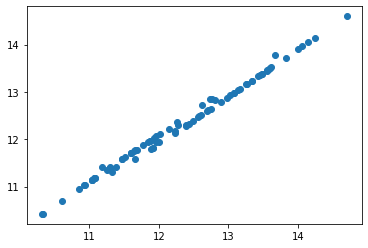

In [520]:
plt.scatter(tmc1_y, svr_cv.best_estimator_.predict(tmc1_X))

In [517]:
r2_score(tmc1_y, svr_cv.best_estimator_.predict(tmc1_X))

0.9982153305181436

## Exporting the hyperparameter optimization results

In [10]:
# collect up the dictionaries for best parameters
best_param_dict = dict()
for name in models.keys():
    best_param_dict[name] = cv_results[name].best_params_
with open("outputs/grid_search/optimized_hparams.yml", "w+") as write_file:
    YAML().dump(best_param_dict, write_file)

## Writing the training reports

In [11]:
best_splits = dict()

for name, log in model_results.items():
    df = pd.DataFrame(log).sort_values(["r2", "combined_error"], ascending=[False, True])
    df.reset_index(inplace=True, drop=True)
    df.to_csv(f"outputs/grid_search/{name}_training_report.csv", index=False)
    best_splits[name] = (df.iloc[0]["train_index"], df.iloc[0]["test_index"])

## Making an overview plot

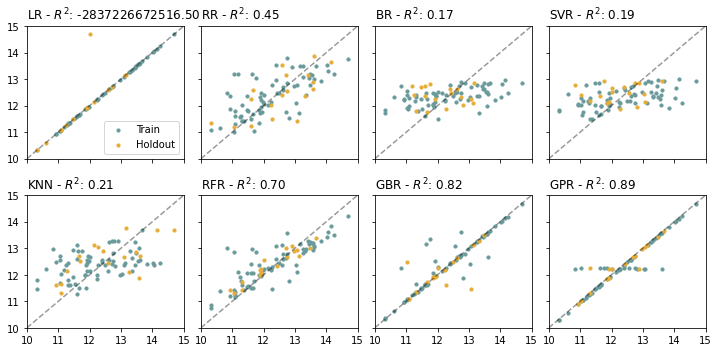

In [13]:
num_models = len(hparams)
formatted_names = {key: key.upper() for key in models.keys()}
formatted_names["linear_regression"] = "LR"
formatted_names["ridge"] = "RR"

fig, axarray = plt.subplots(2, num_models // 2, figsize=(10, 5), sharex=True, sharey=True)

for model_name, ax in zip(models.keys(), axarray.flatten()):
    model = best_models.get(model_name)
    train_split, test_split = best_splits.get(model_name)
    # draw the ideal curve
    ax.plot(np.arange(10, 16), np.arange(10, 16), ls="--", alpha=0.4, color="k")
    ax.scatter(tmc1_y[train_split], model.predict(tmc1_X[train_split]), c="#6B9A9B", label="Train", s=10,)
    ax.scatter(tmc1_y[test_split], model.predict(tmc1_X[test_split]), c="#E6AD39", label="Holdout", s=10,)
    r2 = r2_score(tmc1_y, model.predict(tmc1_X))
    ax.set(xlim=[10, 15], ylim=(10, 15))
    real_name = formatted_names.get(model_name)
    ax.set_title(f"{real_name} - $R^2$: {r2:1.2f}", loc="left")
    if model_name == "linear_regression":
        ax.legend()
fig.tight_layout()

## Data importance estimation

In [599]:
def bootstrap_importance_estimation(estimator, data, seed: int, n_splits: int = 500):
    X, y = data
    splitter = ShuffleSplit(n_splits, test_size=0.2, random_state=seed)
    log = list()
    weights = np.ones((n_splits, y.size))
    test_errors = list()
    for split_index, (train_index, test_index) in enumerate(splitter.split(X, y)):
        train_X, test_X, train_y, test_y = X[train_index], X[test_index], y[train_index], y[test_index]
        result = estimator.fit(train_X, train_y)
        # compute the mean squared error
        train_error = mean_squared_error(train_y, result.predict(train_X))
        test_error = mean_squared_error(test_y, result.predict(test_X))
        log.append(
            {"train_error": train_error, "test_error": test_error, "train_index": train_index, "test_index": test_index}
        )
        test_errors.append(test_error)
        weights[split_index, test_index] = 0.
    # reshape so we can do matrix multiplication
    test_errors = np.asarray(test_errors)[:,None]
    molecule_weights = (weights * test_errors).std(axis=0)
    molecule_weights /= np.min(molecule_weights)
    return log, molecule_weights

In [600]:
bootstrap_log, weights = bootstrap_importance_estimation(best_models["ridge"], (tmc1_X, tmc1_y) ,seed, n_splits=5000)